In [1]:
from tools import HopfieldNetwork
import numpy as np

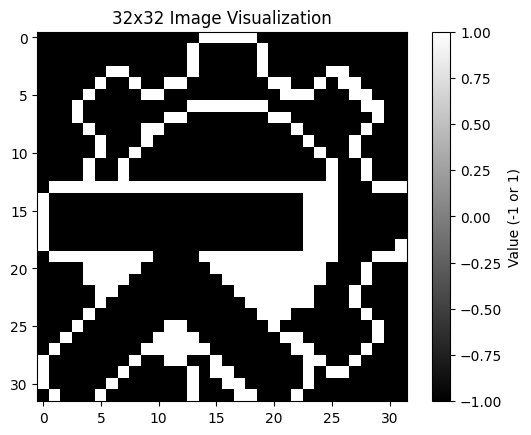

In [4]:
hopfield = HopfieldNetwork(1024)
hopfield.visualize(pattern_index=2)